## Model interpretowalny i jego analiza

*Disclaimer*: Definicje funkcji do pipeline i ich opis powtarza się w pliku z XGBoost.

In [2]:
import pandas as pd
import numpy as np
import joblib
import shap

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, average_precision_score, brier_score_loss, log_loss, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import PartialDependenceDisplay

from sklearn.calibration import calibration_curve
from scipy.special import logit, expit
from sklearn.calibration import CalibratedClassifierCV
from betacal import BetaCalibration

## `Wstępne przygotowanie danych`

Wczytano dane z pliku `zbiór_10.csv`, gdzie zmienną celu była kolumna `default`. Niepotrzebna kolumna `szczegolnaFormaPrawna_Symbol`, zawierająca tę samą wartość dla wszystkich obserwacji, została usunięta. Następnie przygotowano kolumny kategoryczne (`formaWlasnosci_Symbol`, `schemat_wsk_bilans`, `schemat_wsk_rzis`) do użycia w modelu regresji liniowej poprzez One-Hot Encoding. Ponieważ liczba kategorii w tych zmiennych była na tyle niewielka, można argumentować, że nie stanowiło to wycieku danych , gdyż wszystkie kategorie były znane odgórnie. Dla każdej kolumny kategorycznej utworzono odpowiadające jej kolumny binarne, reprezentujące wszystkie możliwe kategorie, a oryginalne kolumny kategoryczne usunięto. Otrzymany zbiór danych podlega dalszym transformacjom w pipeline.

In [3]:
# PRAWDE MOWIAC LEPIEJ BY BYLO TO WRZUCIC W PIPELINE ALE GDY TO PISALISMY NIE WIEDZIELISMY JAK ONE DZIALAJA

data = pd.read_csv("zbiór_10.csv")

X = data.drop(columns=["default"])
y = data["default"]

# dropujemy szczegolna forma wlasnosci (kazdy ma taka sama 117)
X = X.drop(columns="szczegolnaFormaPrawna_Symbol")

unique_values = X['formaWlasnosci_Symbol'].unique()

categorical_cols = ['formaWlasnosci_Symbol']

# lista kolumn OHE odpowiadających symbolom form własności
numeric_cols = [
    'ohe_fw_214','ohe_fw_215','ohe_fw_113','ohe_fw_216','ohe_fw_225','ohe_fw_226',
    'ohe_fw_224','ohe_fw_227','ohe_fw_234','ohe_fw_111','ohe_fw_112','ohe_fw_235',
    'ohe_fw_132','ohe_fw_123','ohe_fw_133','ohe_fw_122','ohe_fw_338', 'ohe_fw_000'
]

# inicjalizacja OneHotEncoder z ustalonymi kategoriami
ohe = OneHotEncoder(
    categories=[sorted([int(c.split('_')[-1]) for c in numeric_cols])],
    sparse_output=False,  # zmiana z sparse -> sparse_output
    drop=None
)

# dopasowanie i transformacja
ohe_array = ohe.fit_transform(X[['formaWlasnosci_Symbol']])

# utworzenie DataFrame z odpowiednimi nazwami kolumn
df_ohe = pd.DataFrame(ohe_array, columns=numeric_cols, index=X.index)

# połączenie z oryginalnym df
df = pd.concat([X, df_ohe], axis=1)
df = df.drop(columns=["formaWlasnosci_Symbol"])

## analogicznie dla kolumny 'schemat_wsk_bilans'

ohe_cols = ['SFJIN_wsk_bilans', 'SFJMI_wsk_bilans', 'SFJMA_wsk_bilans']

# inicjalizacja OneHotEncoder z ustalonymi kategoriami
ohe = OneHotEncoder(
    categories = [['SFJIN', 'SFJMI', 'SFJMA']],
    sparse_output=False,  # zmiana z sparse -> sparse_output
    drop=None
)

# dopasowanie i transformacja
ohe_array = ohe.fit_transform(X[['schemat_wsk_bilans']])

# utworzenie DataFrame z odpowiednimi nazwami kolumn
df_ohe = pd.DataFrame(ohe_array, columns=ohe_cols, index=X.index)

# połączenie z oryginalnym df
df = pd.concat([df, df_ohe], axis=1)
df = df.drop(columns=["schemat_wsk_bilans"])

## i jeszcze raz dla 'schemat_wsk_rzis'

ohe_cols = ['SFJIN_wsk_rzis', 'SFJMI_wsk_rzis', 'SFJMA_wsk_rzis']

# inicjalizacja OneHotEncoder z ustalonymi kategoriami
ohe = OneHotEncoder(
    categories = [['SFJIN', 'SFJMI', 'SFJMA']],
    sparse_output=False,  # zmiana z sparse -> sparse_output
    drop=None
)

# dopasowanie i transformacja
ohe_array = ohe.fit_transform(X[['schemat_wsk_rzis']])

# utworzenie DataFrame z odpowiednimi nazwami kolumn
df_ohe = pd.DataFrame(ohe_array, columns=ohe_cols, index=X.index)

# połączenie z oryginalnym df
df = pd.concat([df, df_ohe], axis=1)
X = df.drop(columns=["schemat_wsk_rzis"])

---
## `PKDKodWoEEncoder` (Weight of Evidence Encoder)

Klasa transformująca zmienną kategoryczną 'pkdKod' na miarę Weight of Evidence (WoE). Służy do przygotowania zmiennych kategorycznych o dużej liczbie unikalnych wartości dla modeli scoringowych.

---

### **Działanie Kluczowe**
* Grupowanie Rzadkich Kategorii: Identyfikuje top_n najczęściej występujących kategorii. Wszystkie pozostałe kategorie (rzadkie) są grupowane w jedną kategorię oznaczoną jako '0'.

* Obliczanie WoE: Dla każdej z topowych kategorii i kategorii '0' oblicza WoE. WoE jest logarytmem naturalnym z ilorazu szans (Good/Bad) w danej grupie, podzielonego przez iloraz szans w całej próbie (Good_Total/Bad_Total).

$$WoE = \ln \left( \frac{P(\text{Good} | \text{Grupa})}{P(\text{Bad} | \text{Grupa})} / \frac{P(\text{Good Total})}{P(\text{Bad Total})} \right)$$

* Wygładzanie (Smoothing): Dodaje wartość smoothing (np. 0.5) do liczebności zdarzeń "Good" i "Bad" (dobrych i złych), aby uniknąć dzielenia przez zero i zmniejszyć wpływ małych prób.

* Transformacja: Zastępuje wartość pkdKod obliczoną wartością WoE. Oryginalna kolumna pkdKod jest usuwana.

In [4]:
class PKDKodWoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, smoothing=0.5):
        self.top_n = top_n
        self.smoothing = smoothing
    
    def fit(self, X, y):
        X = X.copy()
        y = y.copy()
        
        # wybieramy top_n najczęstszych kategorii

        self.top_values_ = X['pkdKod'].value_counts().nlargest(self.top_n).index
        
        # kolumna w ktorej rzadkie wartosci zamieniamy na '0'
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        
        # liczymy woe
        df = pd.DataFrame({'group': grouped, 'target': y})
        agg = df.groupby('group')['target'].agg(['sum', 'count'])
        agg = agg.rename(columns={'sum':'bad', 'count':'total'})
        agg['good'] = agg['total'] - agg['bad']

        agg['bad_s'] = agg['bad'] + self.smoothing
        agg['good_s'] = agg['good'] + self.smoothing

        total_bad = agg['bad_s'].sum()
        total_good = agg['good_s'].sum()

        agg['woe'] = np.log((agg['good_s'] / total_good) / (agg['bad_s'] / total_bad))

        self.woe_map_ = agg['woe'].to_dict()
        self.fallback_ = np.mean(list(self.woe_map_.values()))
        
        return self
    
    def transform(self, X):
        X = X.copy()
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        X['WoE_pkdKod_grouped'] = grouped.map(self.woe_map_).fillna(self.fallback_)
        return X.drop(columns=['pkdKod'])
    
    # blagam zeby to naprawilo shap
    def get_feature_names_out(self, input_features=None):
        """
        Zwraca nazwy kolumn po transformacji.
        Jeśli wejściowa kolumna 'pkdKod' została zastąpiona przez 'WoE_pkdKod_grouped',
        zwróć nową nazwę wraz z pozostałymi kolumnami.
        """
        if input_features is None:
            return np.array(['WoE_pkdKod_grouped'])
        
        new_features = []
        for feat in input_features:
            if feat == 'pkdKod':
                new_features.append('WoE_pkdKod_grouped')
            else:
                new_features.append(feat)
        return np.array(new_features)

---
## `MissingValueIndicatorAndImputer`

Ta klasa jest transformatorem scikit-learn, który realizuje dwie operacje jednocześnie na kolumnach numerycznych: imputację brakujących wartości oraz tworzenie kolumn-wskaźników braków danych.

---

### **Działanie Kluczowe**

* Obsługa Nieskończoności: Zamienia wartości nieskończone (np.inf, -np.inf) na braki danych (np.nan).
* Imputacja: Wykorzystuje SimpleImputer (strategia domyślna to mediana, ale można zmienić np. na mean lub most_frequent) do zastąpienia brakujących wartości. W fazie fit uczy się wartości imputacji, a w transform je stosuje.

* Wskaźnik Braków Danych: Tworzy nową kolumnę dla każdej oryginalnej kolumny, której nazwa kończy się na _mial_braki_danych. Wartość w tej kolumnie wynosi 1, jeśli oryginalna kolumna miała brak danych, i 0 w przeciwnym razie.

* Łączenie: Zwraca ramkę danych zawierającą zaimputowane oryginalne kolumny oraz nowo utworzone kolumny-wskaźniki.

In [5]:
class MissingValueIndicatorAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy

    def fit(self, X, y=None):
        X = X.replace([np.inf, -np.inf], np.nan).copy()
        self.base_cols_ = list(X.columns)

        # kolumny do imputacji
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.base_cols_])

        # nazwy kolumn wskaźników
        self.indicator_cols_ = [f"{c}_mial_braki_danych" for c in self.base_cols_]

        return self

    def transform(self, X):
        X = X.replace([np.inf, -np.inf], np.nan).copy()

        # imputacja
        X_imputed = pd.DataFrame(
            self.imputer_.transform(X[self.base_cols_]),
            columns=self.base_cols_,
            index=X.index
        )

        # wskaźniki braków danych
        indicator_df = X[self.base_cols_].isna().astype(int)
        indicator_df.columns = self.indicator_cols_
        indicator_df.index = X.index

        # łączymy razem
        X_out = pd.concat([X_imputed, indicator_df], axis=1)

        return X_out
    
    def get_feature_names_out(self, input_features=None):
        """
        Zwraca nazwy kolumn po imputacji i dodaniu wskaźników braków danych.
        """
        if input_features is None:
            input_features = self.base_cols_

        # po transformacji mamy oryginalne kolumny + kolumny wskaźników
        return np.array(list(input_features) + [f"{c}_mial_braki_danych" for c in input_features])

---
## `DropConstantColumns` (Usuwanie stałych kolumn)

Prosty transformator, którego zadaniem jest identyfikacja i usunięcie z ramki danych kolumn, które mają **jedną lub zero unikalnych wartości** (są stałe).

---

### **Działanie Kluczowe**

* Fit: W fazie treningu (fit) identyfikuje kolumny, w których liczba unikalnych wartości (nunique()) jest mniejsza lub równa 1. Nazwy tych kolumn są przechowywane w self.cols_to_drop_.
* Transform: W fazie transformacji (transform) usuwa te zidentyfikowane kolumny z ramki danych.

In [6]:
class DropConstantColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols_to_drop_ = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, errors='ignore')
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([] if not hasattr(self, "cols_to_drop_") else [
                col for col in X.columns if col not in self.cols_to_drop_
            ])

        return np.array([col for col in input_features if col not in getattr(self, "cols_to_drop_", [])])

## `CorrelationBasedFeatureSelector`

Ta klasa jest transformatorem scikit-learn służącym do **wykrywania i usuwania silnie skorelowanych cech** w celu redukcji współliniowości oraz poprawy stabilności i interpretowalności modelu regresji liniowej.

---

### **Działanie kluczowe**

* Tworzona jest macierz korelacji pomiędzy wszystkimi cechami numerycznymi.  

*  Dla każdej pary cech, których korelacja przekracza wartość progową, rozpoczyna się proces decyzyjny dotyczący usunięcia jednej z nich.
   - Dla każdej silnie skorelowanej pary obliczana jest bezwzględna korelacja obu cech z wartością docelową (`y`).  
   - Usuwana jest ta cecha, która wykazuje słabszą relację z targetem, co pozwala zachować bardziej informatywną zmienną.

* Zidentyfikowane cechy są zapisywane w atrybucie `to_drop_` i usuwane podczas transformacji danych.

* Transformacja: usuwa z przekazanej ramki danych wszystkie kolumny znajdujące się na liście `to_drop_`, pozostawiając jedynie cechy spełniające kryteria niskiej współkorelacji.

In [7]:
class CorrelationBasedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        # Liczymy macierz korelacji
        corr_matrix = X.corr().abs()

        # Bierzemy tylko górny trójkąt
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        to_drop = []

        # Iterujemy po parach kolumn, które przekraczają próg korelacji
        for col_a in upper.columns:
            # Znajdź kolumny silnie skorelowane z col_a
            highly_corr = upper.index[upper[col_a] > self.threshold].tolist()

            for col_b in highly_corr:
                # Jeśli żadna z kolumn jeszcze nie została usunięta
                if col_a not in to_drop and col_b not in to_drop:
                    
                    # Korelacja każdej z targetem
                    corr_a = abs(np.corrcoef(X[col_a], y)[0,1])
                    corr_b = abs(np.corrcoef(X[col_b], y)[0,1])

                    # Wywalamy tę słabiej skorelowaną z targetem
                    if corr_a < corr_b:
                        to_drop.append(col_a)
                    else:
                        to_drop.append(col_b)

        self.to_drop_ = to_drop
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.to_drop_, errors='ignore')
    
    def get_feature_names_out(self, input_features=None):

        if input_features is None:
            input_features = []
        return np.array([col for col in input_features if col not in getattr(self, "to_drop_", [])])

## `Podział Danych` na zbiór treningowy i testowy


Treningowy (Train): Używany do uczenia modelu.

Testowy (Test): Używany do ostatecznej, niezależnej oceny wydajności gotowego modelu.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2137)

## `Pipeline modelu i dopasowanie klasyfikatora`

* Budowa pipeline  
   - Pipeline składa się z kolejnych kroków przetwarzania danych zdefiniowanych wcześniej i dopasowania modelu:  
     - `PKDKodWoEEncoder(top_n=10, smoothing=0.5)` – kodowanie zmiennej PKD metodą WOE, uwzględniające 10 najważniejszych kategorii
     - `MissingValueIndicatorAndImputer(strategy="median")` – wypełnienie braków danych oraz tworzenie kolumn wskaźnikowych dla braków
     - `DropConstantColumns()` – usuwanie kolumn o stałej wartości
     - `CorrelationBasedFeatureSelector(threshold=0.8)` – usuwanie cech silnie skorelowanych między sobą.  
     - `StandardScaler()` – skalowanie zmiennych
     - `LogisticRegression(...)` – klasyfikator regresji logistycznej

* Definicja siatki parametrów (`param_grid`) 
   - `classifier__C`: poziomy siły regularyzacji [0.001, 0.01, 0.1, 1, 10, 100] 
   - `classifier__penalty`: L1 lub L2
   - `classifier__class_weight`: opcje zrównoważenia klas lub jego brak [None, "balanced", {0: 1, 1: 3}, {0: 1, 1: 5}]

* Walidacja krzyżowa  
   - Użyto `StratifiedKFold` z 5 podziałami i mieszaniem danych 

* Dopasowanie hiperparametów
   - Do przeszukania siatki parametrów zastosowano `GridSearchCV` z użyciem metryki `roc_auc` 
   
* Efekt końcowy
   - Pipeline został dopasowany do danych treningowych (`X_train`, `y_train`) i wybrano najlepszy model na podstawie średniego ROC AUC z walidacji krzyżowej.  
   - Pomimo ponad 70 minut obliczneń model wybrany przez GridSearch nie spełniał naszych oczekiwań
   - Ostatateczne (nieco lepsze) hiperparametry modelu udało nam się przypadkowo zgadnąć

In [ ]:
# pipeline = Pipeline([
#     ("pkd_woe", PKDKodWoEEncoder(top_n=10, smoothing=0.5)),
#     ("missing", MissingValueIndicatorAndImputer(strategy="median")),
#     ("drop_constant", DropConstantColumns()),
#     ("corr_selector", CorrelationBasedFeatureSelector(threshold=0.8)),
#     ("scaler", StandardScaler()),
#     ("classifier", LogisticRegression(
#         random_state=42,
#         class_weight="balanced",
#         max_iter=1000,
#         solver='liblinear'
#     ))
# ])


# param_grid = {
#     "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],  # siła regularyzacji
#     "classifier__penalty": ["l1", "l2"],  # L1 dla selekcji cech, L2 dla stabilności
#     "classifier__class_weight": [None, "balanced", {0: 1, 1: 3}, {0: 1, 1: 5}]
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# grid.fit(X_train, y_train)

In [9]:
best_model = joblib.load('best_regression_model.pkl')

best_model.fit(X_train, y_train)

Pipeline(steps=[('pkd_woe', PKDKodWoEEncoder()),
                ('missing', MissingValueIndicatorAndImputer()),
                ('drop_constant', DropConstantColumns()),
                ('corr_selector',
                 CorrelationBasedFeatureSelector(threshold=0.8)),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=2, class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

In [10]:
## komiczna sprawa jednak zgadlem lepsze parametry niz tamten przeklety grid search xdddd

# finalny pipeline z lepszymi parametrami

# best_model = Pipeline([
#     ("pkd_woe", PKDKodWoEEncoder(top_n=10, smoothing=0.5)),
#     ("missing", MissingValueIndicatorAndImputer(strategy="median")),
#     ("drop_constant", DropConstantColumns()),
#     ("corr_selector", CorrelationBasedFeatureSelector(threshold=0.8)),
#     ("scaler", StandardScaler()),
#     ("classifier", LogisticRegression(
#         random_state=42,
#         solver='liblinear',  
#         C= 2,                # troche mniej przeuczony niz gdy bylo 10 
#         penalty='l2',        
#         class_weight='balanced', 
#         max_iter=1000
#     ))
# ])

Funkcja `calculate_ks_score` jest funkcją pomocniczą do obliczania statystyki Kołmogorowa-Smirnowa dla przewidywanych prawdopodobieństw klasyfikatora.

In [11]:
# Statystyka KS - z jakichs przyczyn biblioteki sie buntowaly
def calculate_ks_score(y_true, y_pred_proba):
    scores_0 = y_pred_proba[y_true == 0]
    scores_1 = y_pred_proba[y_true == 1]
    ks_stat, _ = ks_2samp(scores_1, scores_0)
    return ks_stat

In [ ]:
## metryki

# Predykcje na zbiorze testowym
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)


print("=== OCENA JAKOŚCI MODELU - ZBIÓR TRENINGOWY ===")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_train, y_train_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_train, y_train_pred_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_train, y_train_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")

ks_stat_train = calculate_ks_score(y_train, y_train_pred_proba)
print(f"KS Statistic: {ks_stat_train:.4f}")

print("=== OCENA JAKOŚCI MODELU - ZBIÓR TESTOWY ===")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

ks_stat = calculate_ks_score(y_test, y_pred_proba)
print(f"KS Statistic: {ks_stat:.4f}")

=== OCENA JAKOŚCI MODELU - ZBIÓR TRENINGOWY ===
ROC AUC: 0.8492
PR AUC: 0.3160
Log Loss: 0.5029
Brier Score: 0.1738
Accuracy: 0.6762
Precision: 0.1480
Recall: 0.8647
F1-Score: 0.2527
KS Statistic: 0.5532
=== OCENA JAKOŚCI MODELU - ZBIÓR TESTOWY ===
ROC AUC: 0.6902
PR AUC: 0.1434
Log Loss: 0.6810
Brier Score: 0.1949
Accuracy: 0.6411
Precision: 0.0997
Recall: 0.6800
F1-Score: 0.1739
KS Statistic: 0.3353


# `Interpretacja metryk`

Ocena jakości modelu na zbiorze treningowym pokazuje bardzo dobre dopasowanie, z wartością ROC AUC równą 0.8492 oraz KS Statistic 0.5532, co wskazuje na znaczną zdolność modelu do rozróżniania klas. Jednakże na zbiorze testowym ROC AUC spada do 0.6902, a KS Statistic do 0.3353, co sugeruje znaczne przetrenowanie modelu. 

Model bardzo mocno poświęcił precyzję na rzecz recallu – na zbiorze treningowym recall wynosi 0.8647 przy precyzji zaledwie 0.1480, a na zbiorze testowym 0.6800 przy precyzji 0.0997. Jest to świadoma decyzja projektowa, ponieważ lepiej nie przyznać kredytu dobremu klientowi niż przyznać kredyt, który nie zostanie spłacony.

Wyniki accuracy (0.6762 na treningu, 0.6411 na teście) są niższe niż w przypadku modelu, który przewiduje zawsze spłatę kredytu, ale w tym przypadku interpretacja jest zgodna z celem biznesowym – lepiej zawyżyć prawdopodobieństwo niespłacenia niż je zaniżyć. Pozostałe metryki, takie jak PR AUC, F1-Score czy Brier Score, również odzwierciedlają kompromis między wysokim recall a niską precyzją.

Większość obserwowanych problemów z jakością modelu, w tym niska precyzja przy wysokim recall oraz spadek metryk na zbiorze testowym, wynika głównie z nierównowagi klas. Klasa pozytywna (niespłacone kredyty) stanowiła niewielki odsetek danych, co powoduje, że model jest bardziej podatny na błędy w przewidywaniu rzadkiej klasy i wymaga kompromisu między różnymi metrykami oceny jakości.

## `Pobieranie nazw cech i przetworzonych danych po pipeline`

Funkcja `get_feature_names_and_transformed_X` umożliwia uzyskanie listy nazw cech oraz DataFrame po wszystkich transformacjach w pipeline, z wyjątkiem klasyfikatora. Została zaimplementowana przed dodaniem funckji `get_feature_names_out` do własnych elementów pipeline i była jej tymczasowym zamiennikiem.

* Dopasowanie i transformacja
   - Iteruje po wszystkich krokach pipeline’u oprócz klasyfikatora.  
   - Wykonuje dopasowanie i transformację danych dla każdego kroku, jeśli jest to wymagane.

* Obsługa nazw kolumn  
   - Jeśli transformacja zwraca DataFrame, zachowywane są oryginalne nazwy kolumn.  
   - Jeśli zwraca tablicę NumPy, nazwy kolumn generowane są automatycznie lub pobierane z dostępnych atrybutów transformera (`columns_` lub `get_feature_names_out`).

* Wynik końcowy 
   - Zwraca zestaw nazw cech oraz DataFrame po wszystkich transformacjach
   - Funkcja umożliwia również śledzenie liczby cech po każdym kroku przetwarzania, co umożliwia wgląd w proces preprocessingu


In [ ]:
# to było zaimplementowanie przed dodaniem get feature names do pipeline, ale dalej jest za duzo kodu zeby juz to usunac 💀💀💀
# Pobieranie nazw cech i nowego X_train po preprocessing
def get_feature_names_and_transformed_X(pipeline, X, y=None):
    """
    Pobiera nazwy cech i zwraca DataFrame po wszystkich transformacjach w pipeline,
    pomijając ostatni krok (klasyfikator).
    
    pipeline: dopasowany sklearn Pipeline
    X: dane wejściowe (DataFrame)
    y: opcjonalnie etykiety (potrzebne dla własnych transformerów)
    
    Zwraca:
    - feature_names: lista nazw cech po transformacjach
    - X_transformed: DataFrame po transformacjach
    """
    X_temp = X.copy()
    
    for step_name, step in list(pipeline.named_steps.items())[:-1]:  # pomijamy classifier
        if hasattr(step, 'fit') and y is not None:
            step.fit(X_temp, y)
        
        # Transformacja
        X_transformed = step.transform(X_temp)
        
        
        if isinstance(X_transformed, pd.DataFrame):
            X_temp = X_transformed
        else:
            # próbujemy wziąć columns_ z transformera
            if hasattr(step, 'columns_'):
                cols = step.columns_
            elif hasattr(step, 'get_feature_names_out'):
                cols = step.get_feature_names_out(X_temp.columns)
            else:
                cols = [f"{step_name}_feature_{i}" for i in range(X_transformed.shape[1])]
            
            X_temp = pd.DataFrame(X_transformed, columns=cols)
        
        print(f"Po kroku '{step_name}': {X_temp.shape[1]} cech")
    
    feature_names = X_temp.columns.tolist()
    
    return feature_names, X_temp



feature_names, X_train_transformed = get_feature_names_and_transformed_X(best_model, X_train, y_train)

Po kroku 'pkd_woe': 239 cech
Po kroku 'missing': 478 cech
Po kroku 'drop_constant': 249 cech
Po kroku 'corr_selector': 141 cech
Po kroku 'scaler': 141 cech



=== INTERPRETACJA GLOBALNA ===
Top 15 najważniejszych cech:
                                        feature  coefficient  odds_ratio  \
18                               Kapital_wlasny    -4.087620    0.016779   
6                     Naleznosci_dlugoterminowe    -3.729005    0.024017   
98         wsk_poziom_kapitalu_obrotowego_netto    -3.262575    0.038290   
35   Zobowiazania_dostaw_uslug_pow12m_pozostale    -2.513877    0.080954   
110                    wsk_zast_kapitalu_obcego    -2.199504    0.110858   
93               wsk_poziom_kosztow_finansowych    -2.128323    0.119037   
106                       wsk_struktura_majatku    -2.064452    0.126888   
16                             Srodki_pieniezne    -2.045704    0.129289   
48                                      dotacje    -1.921690    0.146359   
77               wsk_zadluzenia_pozyczki_dlugie     1.873151    6.508771   
52                            przychody_odsetki     1.726463    5.620736   
17           Rozliczenia_mi

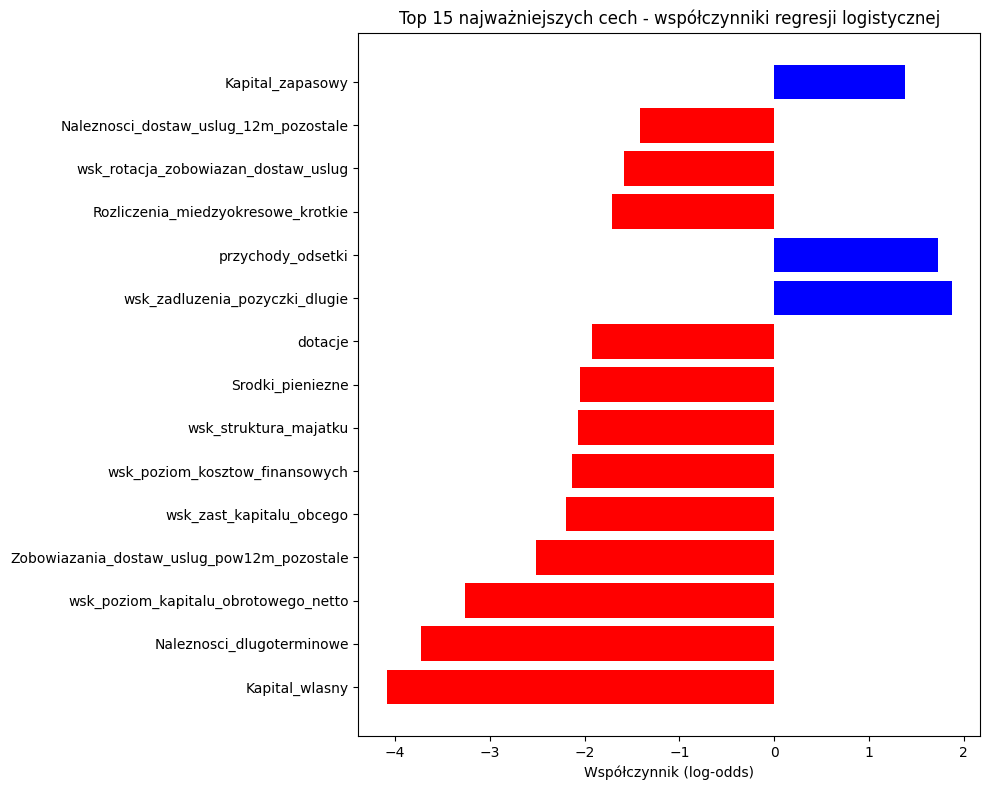

In [31]:
# Analiza współczynników

# wyciagamy klasyfikator z pipeline
classifier = best_model.named_steps['classifier']
coefficients = classifier.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'odds_ratio': odds_ratios,
    'abs_importance': np.abs(coefficients)
}).sort_values('abs_importance', ascending=False)

print("\n=== INTERPRETACJA GLOBALNA ===")
print("Top 15 najważniejszych cech:")
print(feature_importance_df.head(15))

# Wizualizacja współczynników
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel('Współczynnik (log-odds)')
plt.title('Top 15 najważniejszych cech - współczynniki regresji logistycznej')
plt.tight_layout()
plt.show()

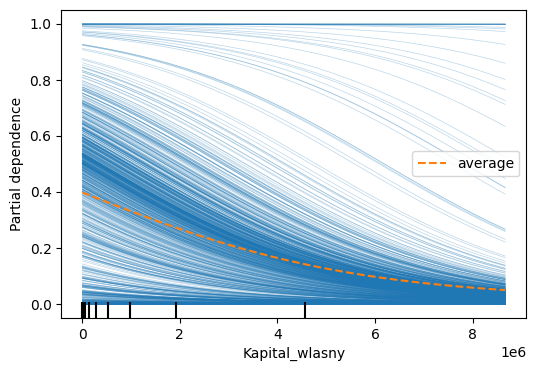

In [15]:
# ogolnie PDP nie ma najmniejszego sensu bo wszystkie dane sa od siebie bardzo mocno zalezne
# ice niebieskie pdp zolte

fig, ax = plt.subplots(figsize=(6, 4))  # możesz zmienić rozmiar
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['Kapital_wlasny'],
    kind="both",
    grid_resolution=30,
    ax=ax  # przypisujemy do naszej osi
)
plt.show()

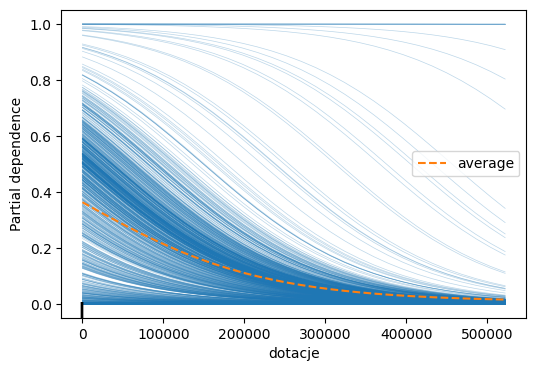

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))  # lub dowolny rozmiar
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['dotacje'],
    kind="both",
    grid_resolution=30,
    percentiles=(0.01, 0.99),
    ax=ax  # przypisujemy do naszej osi
)
plt.show()

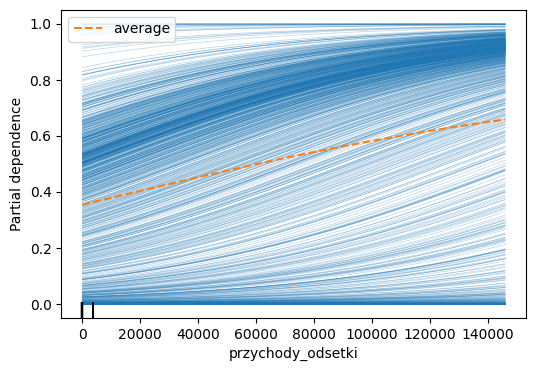

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))  # lub dowolny rozmiar
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['przychody_odsetki'],
    kind="both",
    grid_resolution=30,
    percentiles=(0.01, 0.99),
    ax=ax  # przypisujemy do naszej osi
)
plt.show()

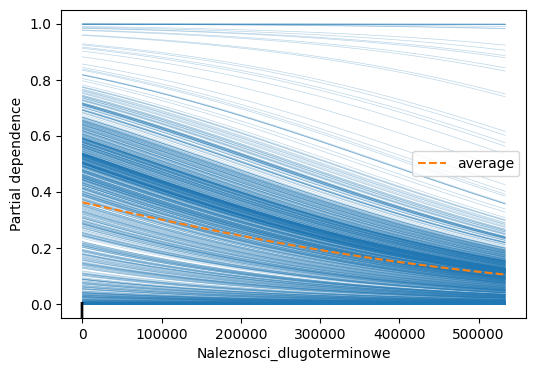

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))  # lub dowolny rozmiar
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['Naleznosci_dlugoterminowe'],
    kind="both",
    grid_resolution=30,
    percentiles=(0.01, 0.99),
    ax=ax  # przypisujemy do naszej osi
)
plt.show()

In [19]:
# --- Wczytanie całego słownika ---
wyniki = joblib.load("wyniki_analizy.joblib")

# --- Rozpakowanie na stare zmienne ---
case_tp = wyniki["case_tp"]
case_tn = wyniki["case_tn"]
case_fp = wyniki["case_fp"]
case_fn = wyniki["case_fn"]

tp_idx = wyniki["tp_idx"]
tn_idx = wyniki["tn_idx"]
fp_idx = wyniki["fp_idx"]
fn_idx = wyniki["fn_idx"]

shap_values = wyniki["shap_values"]

# --- Przygotowanie danych testowych ---
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# # --- Predykcje ---
# y_pred = best_model.predict(X_test_df)
# y_prob = best_model.predict_proba(X_test_df)[:, 1]

# # --- Identyfikacja przypadków ---
# true_pos_mask = (y_test == 1) & (y_pred == 1)
# true_neg_mask = (y_test == 0) & (y_pred == 0)
# false_pos_mask = (y_test == 0) & (y_pred == 1)
# false_neg_mask = (y_test == 1) & (y_pred == 0)

# true_pos = X_test_df[true_pos_mask]
# true_neg = X_test_df[true_neg_mask]
# false_pos = X_test_df[false_pos_mask]
# false_neg = X_test_df[false_neg_mask]

# # --- Wybór ekstremalnych przypadków ---
# case_tp = true_pos.iloc[np.argmax(y_prob[true_pos_mask])]
# case_tn = true_neg.iloc[np.argmin(y_prob[true_neg_mask])]
# case_fp = false_pos.iloc[np.argmax(y_prob[false_pos_mask])]
# case_fn = false_neg.iloc[np.argmin(y_prob[false_neg_mask])]

# # --- Tworzymy SHAP Explainer dla klasy 1 na całym pipeline ---
# explainer = shap.Explainer(lambda X: best_model.predict_proba(X)[:, 1], X_train)

# # --- Obliczamy wartości SHAP dla testowego zbioru ---
# shap_values = explainer(X_test_df)

# # --- Znalezienie indeksów przypadków ---
# tp_idx = X_test_df.index.get_loc(case_tp.name)
# tn_idx = X_test_df.index.get_loc(case_tn.name)
# fp_idx = X_test_df.index.get_loc(case_fp.name)
# fn_idx = X_test_df.index.get_loc(case_fn.name)


# wyniki = {
#     "case_tp": case_tp,
#     "case_tn": case_tn,
#     "case_fp": case_fp,
#     "case_fn": case_fn,
#     "tp_idx": tp_idx,
#     "tn_idx": tn_idx,
#     "fp_idx": fp_idx,
#     "fn_idx": fn_idx,
#     "shap_values": shap_values
# }


# joblib.dump(wyniki, "wyniki_analizy.joblib")

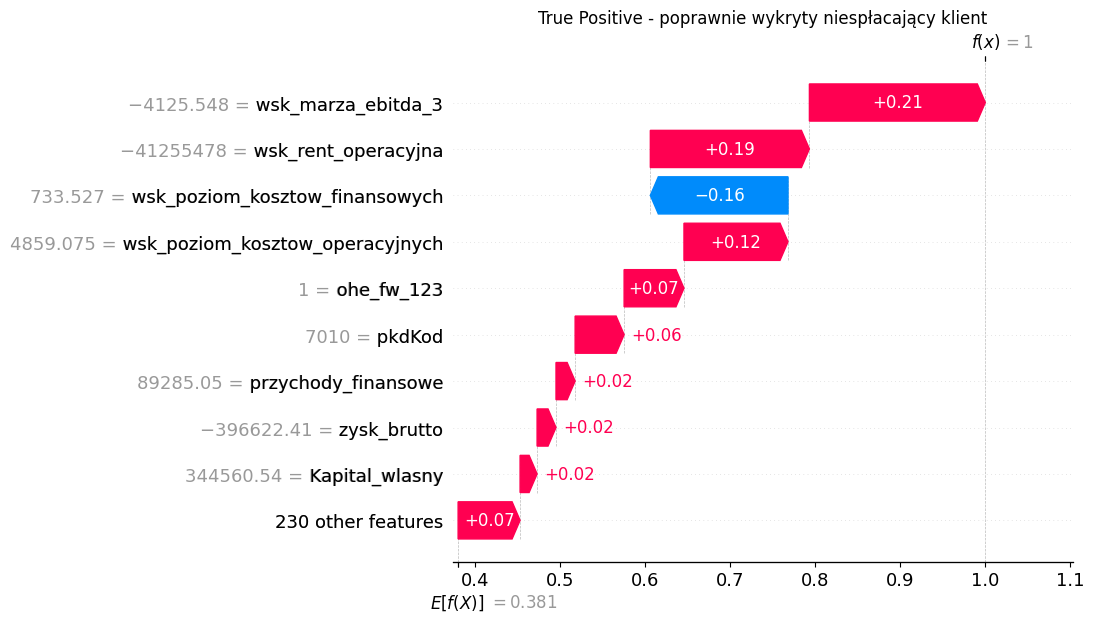

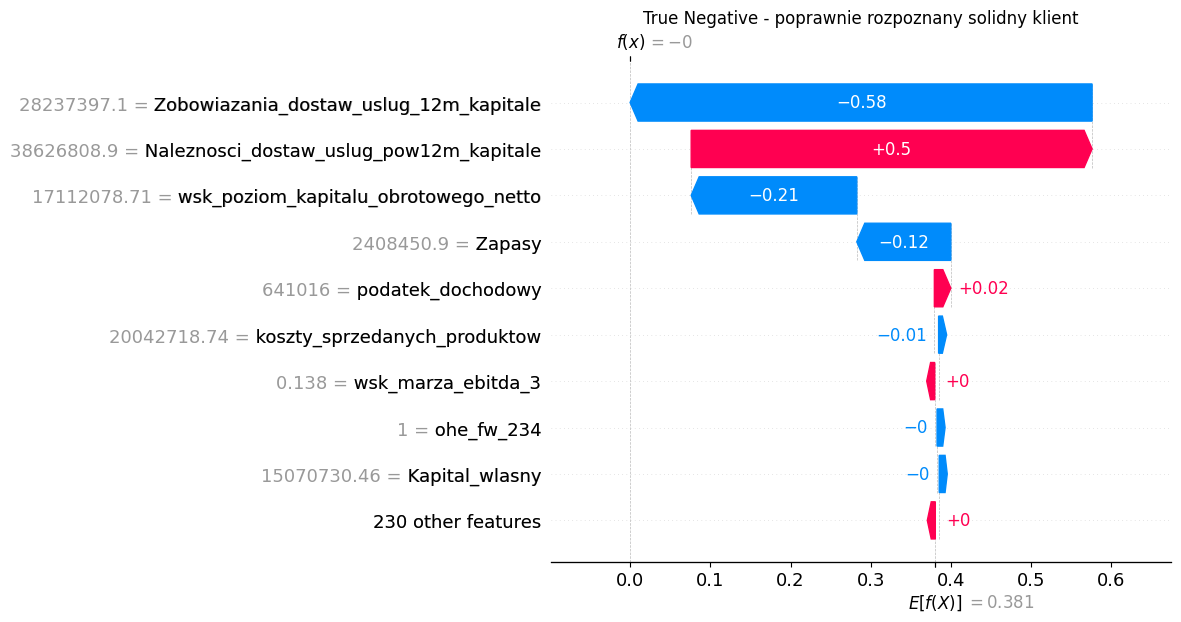

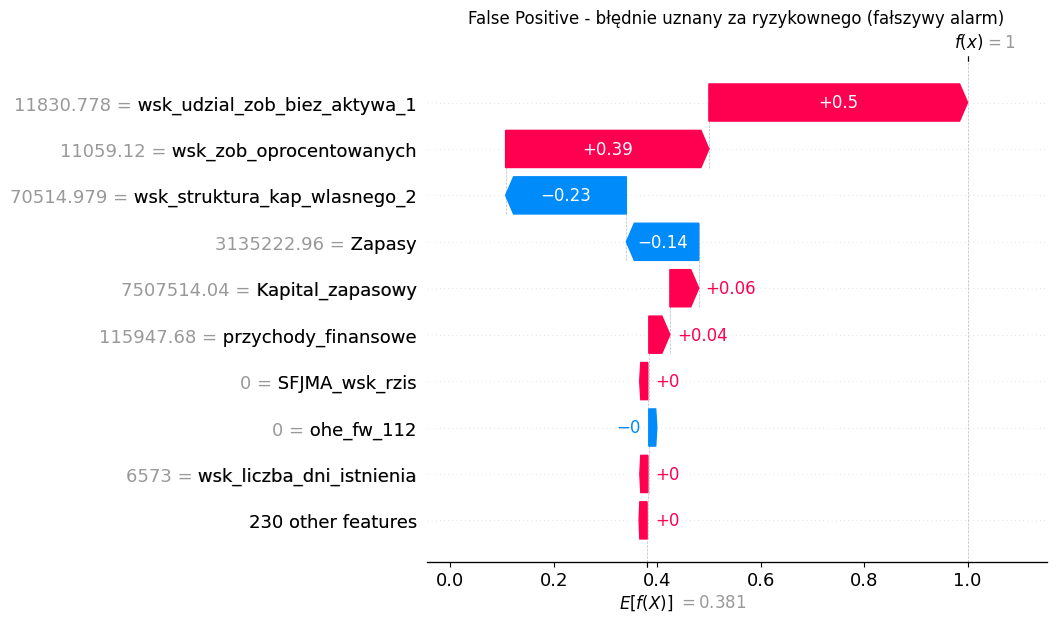

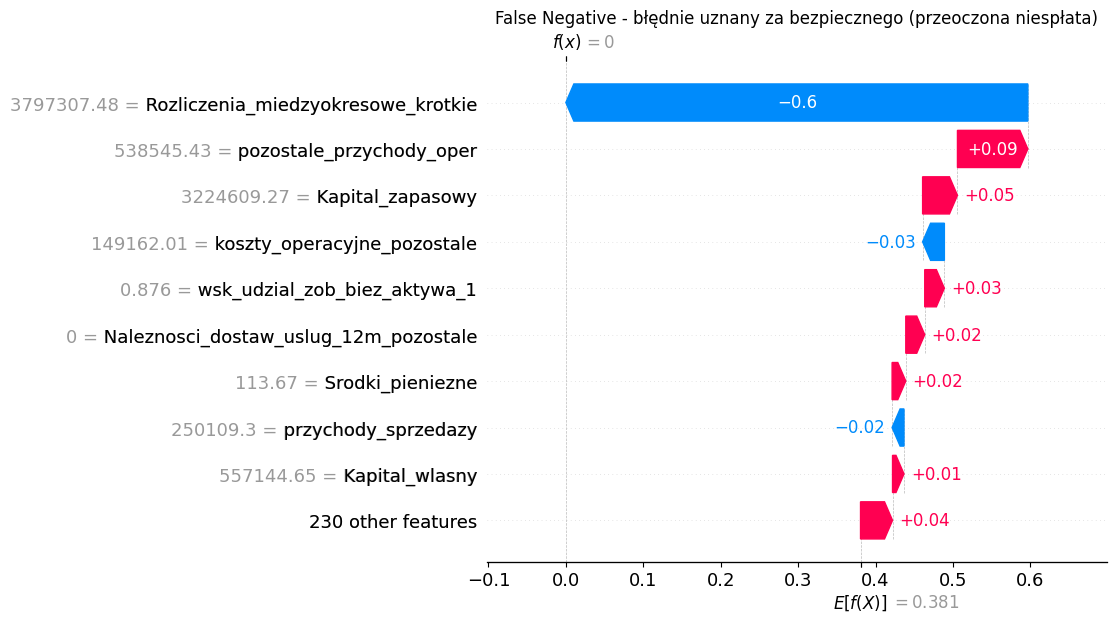

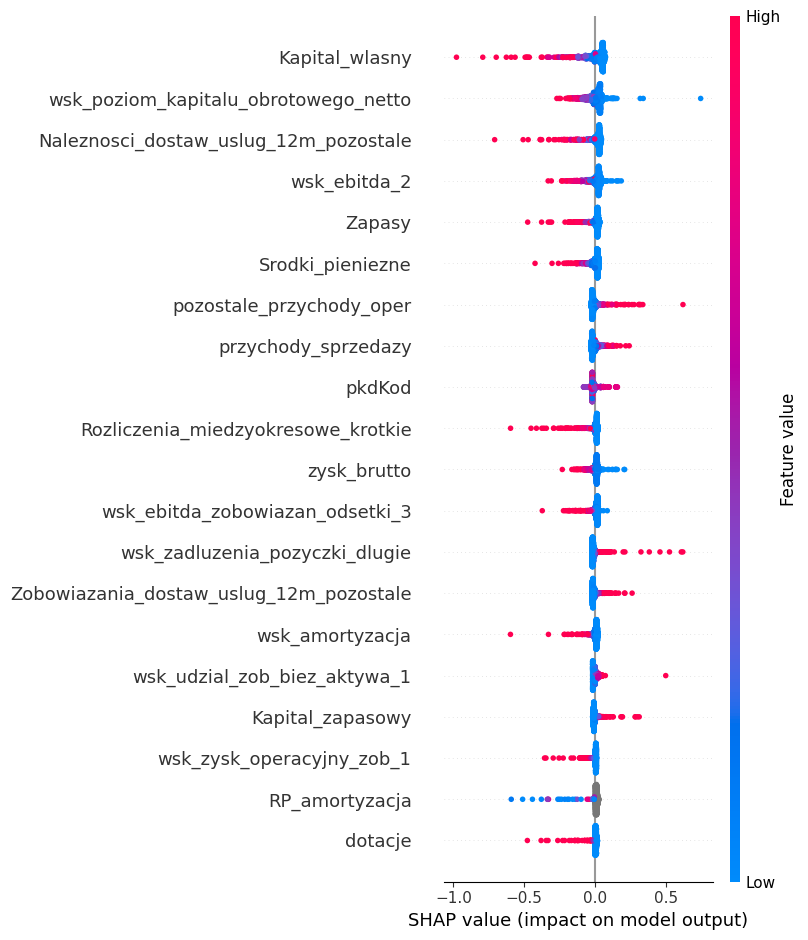

In [20]:
# --- Funkcja do wykresów SHAP ---
def plot_case(case_idx, title):
    shap.waterfall_plot(shap_values[case_idx], show=False)
    plt.title(title, fontsize=12)
    plt.show()

# --- Wyświetlenie 4 wykresów ---
plot_case(tp_idx, "True Positive - poprawnie wykryty niespłacający klient")
plot_case(tn_idx, "True Negative - poprawnie rozpoznany solidny klient")
plot_case(fp_idx, "False Positive - błędnie uznany za ryzykownego (fałszywy alarm)")
plot_case(fn_idx, "False Negative - błędnie uznany za bezpiecznego (przeoczona niespłata)")

# --- Opcjonalny globalny summary plot ---
shap.summary_plot(shap_values.values, X_test_df)

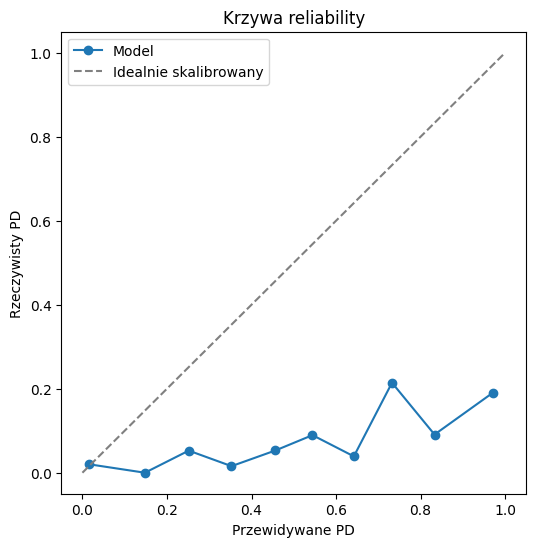

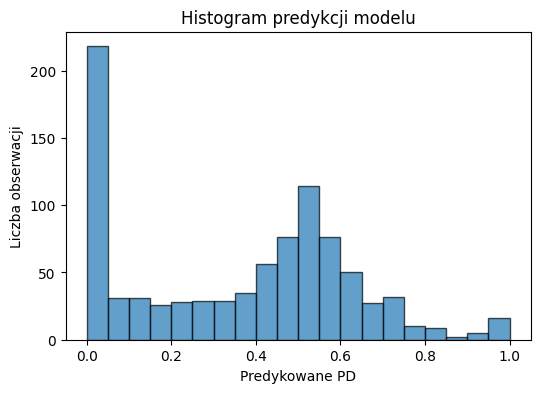

Brier score: 0.1949
Kalibracja (component of Brier): 0.1441
Rozdzielczość (component of Brier): 0.0025
ECE: 0.3053
ACE: 0.5830


In [21]:
# diagnostyka pre-cal
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
y_prob = best_model.predict_proba(X_test_df)[:, 1]


# ---------- 1. Krzywa reliability ----------
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Idealnie skalibrowany')
plt.xlabel("Przewidywane PD")
plt.ylabel("Rzeczywisty PD")
plt.title("Krzywa reliability")
plt.legend()
plt.show()

# ---------- 2. Histogram predykcji ----------
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Predykowane PD")
plt.ylabel("Liczba obserwacji")
plt.title("Histogram predykcji modelu")
plt.show()

# ---------- 3. Brier score z dekompozycją ----------
# Brier score
brier = brier_score_loss(y_test, y_prob)
print(f"Brier score: {brier:.4f}")

# Dekompzycja: kalibracja vs rozdzielczość
# Na podstawie formuły Murphy (Brier = uncertainty - resolution + calibration)
p_mean = np.mean(y_test)
uncertainty = p_mean * (1 - p_mean)
# Używamy reliability curve do dekompozycji
bin_counts, bin_edges = np.histogram(y_prob, bins=10)
bin_indices = np.digitize(y_prob, bins=bin_edges, right=True)
calibration = 0.0
resolution = 0.0
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    if np.sum(mask) == 0:
        continue
    p_bin = np.mean(y_test[mask])
    n_bin = np.sum(mask)
    calibration += n_bin * (p_bin - np.mean(y_prob[mask]))**2
    resolution += n_bin * (p_bin - p_mean)**2
calibration /= len(y_prob)
resolution /= len(y_prob)
print(f"Kalibracja (component of Brier): {calibration:.4f}")
print(f"Rozdzielczość (component of Brier): {resolution:.4f}")

# ---------- 4. ECE i ACE ----------
# ECE (Expected Calibration Error)
ece = 0.0
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    if np.sum(mask) == 0:
        continue
    p_bin = np.mean(y_test[mask])
    p_pred_bin = np.mean(y_prob[mask])
    ece += (np.sum(mask)/len(y_prob)) * abs(p_bin - p_pred_bin)
print(f"ECE: {ece:.4f}")

# ACE (Adaptive Calibration Error)
# ACE: średnia wagi odwrotnej do liczności binu, większa waga rzadkich binów
ace = 0.0
total_weight = 0.0
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    n_bin = np.sum(mask)
    if n_bin == 0:
        continue
    weight = 1 / n_bin
    p_bin = np.mean(y_test[mask])
    p_pred_bin = np.mean(y_prob[mask])
    ace += weight * abs(p_bin - p_pred_bin)
    total_weight += weight
ace /= total_weight
print(f"ACE: {ace:.4f}")

Brier score (surowe PD): 0.1949
Średnia PD (surowe PD): 35.8624%
Brier score (Platt): 0.0518
Średnia PD (Platt): 6.5135%
Brier score (Isotonic): 0.0503
Średnia PD (Isotonic): 6.4272%
Brier score (Beta): 0.0550
Średnia PD (Beta): 6.5784%


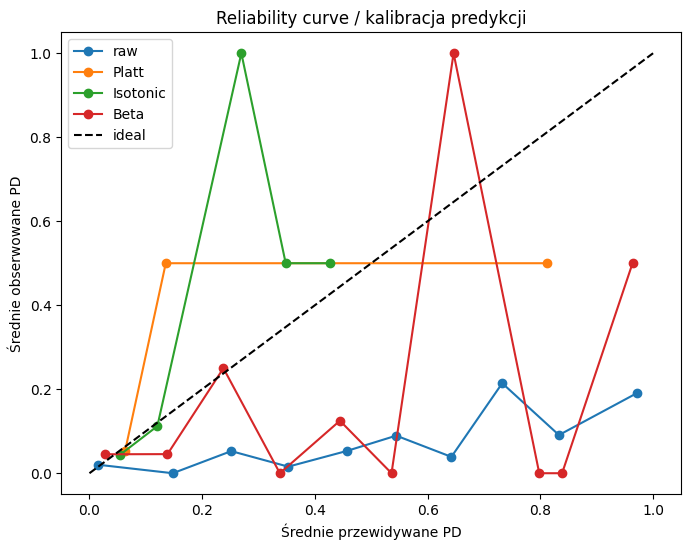

In [22]:
# --------------------------------------------------
# Surowe predykcje z modelu
# --------------------------------------------------
y_pred_train = best_model.predict_proba(X_train)[:,1]
y_pred_test = best_model.predict_proba(X_test)[:,1]

# --------------------------------------------------
# 1️⃣ Platt / Isotonic calibration z CV
# --------------------------------------------------
platt_calibrator = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=5)
platt_calibrator.fit(X_train, y_train)
y_cal_platt = platt_calibrator.predict_proba(X_test)[:,1]

iso_calibrator = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=5)
iso_calibrator.fit(X_train, y_train)
y_cal_iso = iso_calibrator.predict_proba(X_test)[:,1]

# --------------------------------------------------
# 2️⃣ Beta calibration
# --------------------------------------------------

bc = BetaCalibration()
bc.fit(y_pred_train, y_train)
y_cal_beta = bc.predict(y_pred_test)


# --------------------------------------------------
# Ewaluacja: Brier score i średnia PD
# --------------------------------------------------
def evaluate(y_true, y_pred, label):
    brier = brier_score_loss(y_true, y_pred)
    print(f"Brier score ({label}): {brier:.4f}")
    print(f"Średnia PD ({label}): {np.mean(y_pred):.4%}")

evaluate(y_test, y_pred_test, "surowe PD")
evaluate(y_test, y_cal_platt, "Platt")
evaluate(y_test, y_cal_iso, "Isotonic")
evaluate(y_test, y_cal_beta, "Beta")

# --------------------------------------------------
# Reliability curve (krzywa kalibracji)
# --------------------------------------------------
plt.figure(figsize=(8,6))
for y_cal, label in zip([y_pred_test, y_cal_platt, y_cal_iso, y_cal_beta],
                        ["raw", "Platt", "Isotonic", "Beta"]):
    prob_true, prob_pred = calibration_curve(y_test, y_cal, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    
plt.plot([0,1],[0,1], 'k--', label='ideal')
plt.xlabel("Średnie przewidywane PD")
plt.ylabel("Średnie obserwowane PD")
plt.title("Reliability curve / kalibracja predykcji")
plt.legend()
plt.show()

Średnia PD po isotonic: 0.06427154884228659
Średnia PD po isotonic + calibration-in-the-large: 0.040000000042964
Brier raw:      0.1949144532233877
Brier isotonic: 0.05031601922950263
Brier global:   0.050857223062516554
ECE raw:        0.3091018896361621
ECE isotonic:   0.012119081238883066
ECE global:     0.016325726578241058


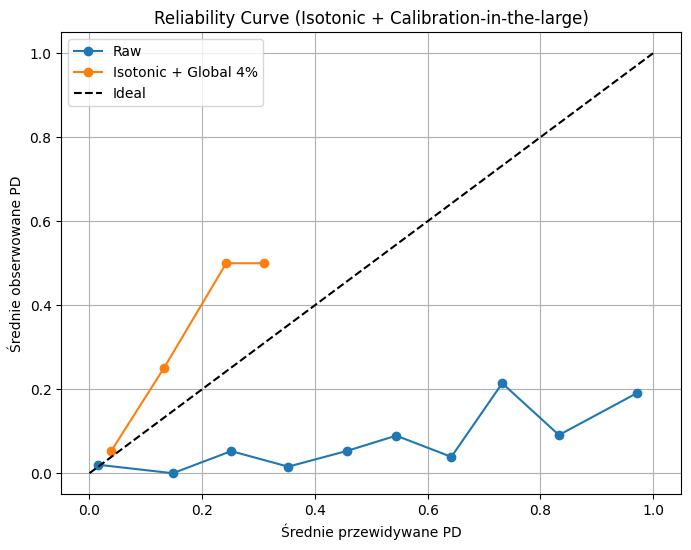

In [23]:
y_pred_train = best_model.predict_proba(X_train)[:, 1]
y_pred_test  = best_model.predict_proba(X_test)[:, 1]

# ---------------------------------------
# 1. Isotonic calibration
# ---------------------------------------
iso_calibrator = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=5)
iso_calibrator.fit(X_train, y_train)

y_iso_train = iso_calibrator.predict_proba(X_train)[:, 1]
y_iso_test  = iso_calibrator.predict_proba(X_test)[:, 1]

# ---------------------------------------
# 2. Calibration-in-the-large do 4%
# ---------------------------------------
target_pd = 0.04

y_iso_test_clip = np.clip(y_iso_test, 1e-6, 1 - 1e-6)

y_iso_global = y_iso_test_clip.copy()
for _ in range(5):
    delta = logit(target_pd) - logit(np.mean(y_iso_global))
    y_iso_global = expit(logit(y_iso_global) + delta)

print("Średnia PD po isotonic:", np.mean(y_iso_test))
print("Średnia PD po isotonic + calibration-in-the-large:", np.mean(y_iso_global))


brier_raw      = brier_score_loss(y_test, y_pred_test)
brier_iso      = brier_score_loss(y_test, y_iso_test)
brier_global   = brier_score_loss(y_test, y_iso_global)

print("Brier raw:     ", brier_raw)
print("Brier isotonic:", brier_iso)
print("Brier global:  ", brier_global)

# jak pobralem z ece z jakiejs biblioteki to odinstalowala mi matloptlib XDDDD
def ECE(y_true, y_prob, n_bins=20):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.sum(idx) > 0:
            bin_true = y_true[idx].mean()
            bin_pred = y_prob[idx].mean()
            ece += (np.sum(idx) / len(y_prob)) * abs(bin_true - bin_pred)
    return ece

ece_raw    = ECE(y_test,   y_pred_test,   n_bins=20)
ece_iso    = ECE(y_test,   y_iso_test,    n_bins=20)
ece_global = ECE(y_test,   y_iso_global,  n_bins=20)

print("ECE raw:       ", ece_raw)
print("ECE isotonic:  ", ece_iso)
print("ECE global:    ", ece_global)

# ---------------------------------------
# 3. Wykres: reliability curve
# ---------------------------------------
plt.figure(figsize=(8,6))

# Raw
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_pred_test, n_bins=10)
plt.plot(prob_pred_raw, prob_true_raw, "o-", label="Raw")


# Isotonic + global shift
prob_true_glob, prob_pred_glob = calibration_curve(y_test, y_iso_global, n_bins=10)
plt.plot(prob_pred_glob, prob_true_glob, "o-", label="Isotonic + Global 4%")

# Ideal line
plt.plot([0, 1], [0, 1], "k--", label="Ideal")

plt.xlabel("Średnie przewidywane PD")
plt.ylabel("Średnie obserwowane PD")
plt.title("Reliability Curve (Isotonic + Calibration-in-the-large)")
plt.legend()
plt.grid(True)
plt.show()

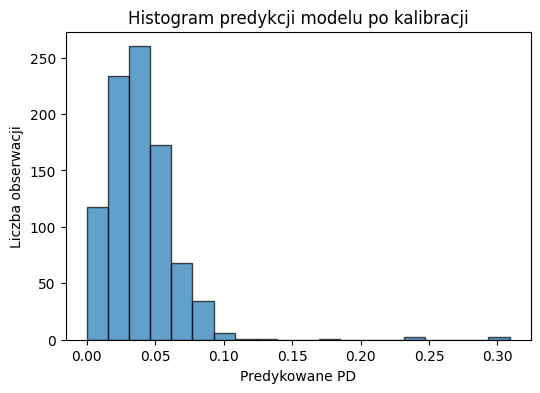

In [24]:
# histogram predykcji  po kalibracji
plt.figure(figsize=(6,4))
plt.hist(y_iso_global, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Predykowane PD")
plt.ylabel("Liczba obserwacji")
plt.title("Histogram predykcji modelu po kalibracji")
plt.show()

In [25]:
# skopiowane z kodu Kamili :))

COST_TP = 0
COST_FP = 5
COST_FN = 40
COST_TN = 3

def cost_for_threshold(y_true, p, thr):
    """Oblicza całkowity koszt dla danego progu."""
    yhat = (p >= thr).astype(int)
    
    # yhat=1 (Odmów), yhat=0 (Udziel)
    # y_true=1 (Default), y_true=0 (Spłacił)
    
    tp = np.sum((yhat==1) & (y_true==1)) # Odmówiono złemu (OK)
    fp = np.sum((yhat==1) & (y_true==0)) # Odmówiono dobremu (Koszt FP)
    fn = np.sum((yhat==0) & (y_true==1)) # Udzielono złemu (Koszt FN)
    tn = np.sum((yhat==0) & (y_true==0)) # Udzielono dobremu (Zysk TN)
    
    total_cost = tp*COST_TP + fp*COST_FP + fn*COST_FN + tn*COST_TN
    return total_cost, tp, fp, fn, tn

def sweep_costs(y_true, p, n=201):
    """Testuje wszystkie progi od 0 do 1."""
    thrs = np.linspace(0,1,n)
    costs, details = [], []
    for t in thrs:
        c, tp, fp, fn, tn = cost_for_threshold(y_true, p, t)
        costs.append(c); details.append((tp,fp,fn,tn))
    return thrs, np.array(costs), details

Rozpoczynam analizę kosztów dla 900 obserwacji...


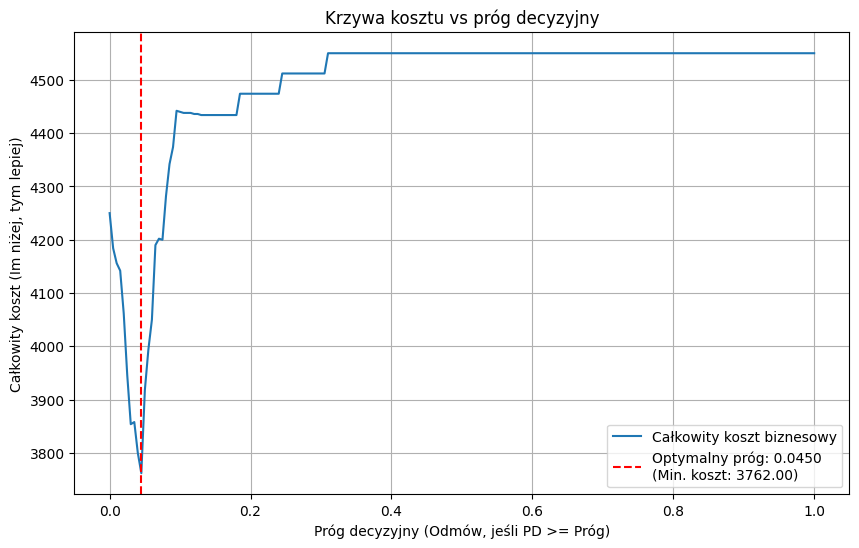


--- Wyniki Optymalnego Progu Biznesowego ---
Optymalny próg (minimalizujący koszt): 0.0450
Minimalny osiągnięty koszt: 3762.00

Macierz pomyłek dla tego progu:
  Prawdziwie Pozytywni (TP - Odmówiono złym): 37
  Fałszywie Pozytywni (FP - Odmówiono dobrym): 346  (Koszt: 1730)
  Fałszywie Negatywni (FN - Udzielono złym):  13  (Koszt: 520)
  Prawdziwie Negatywni (TN - Udzielono dobrym): 504  (Zysk: 1512)

Stopa akceptacji (udzielono kredytu): 57.44%


In [26]:
if 'y_test' in locals() and 'y_iso_global' in locals():
    
    # Używamy Twoich prawdziwych etykiet testowych
    y_true_data = y_test
    # Używamy Twoich prognoz po kalibracji Isotonic + Shift 4%
    p_data = y_iso_global 

    print(f"Rozpoczynam analizę kosztów dla {len(p_data)} obserwacji...")
    
    thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)
    
    # Znajdujemy próg, który MINIMALIZUJE całkowity koszt
    best_idx = int(np.argmin(costs))
    best_thr_cost = float(thrs[best_idx])
    best_cost = costs[best_idx]
    best_tp, best_fp, best_fn, best_tn = details[best_idx]

    # Rysowanie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(thrs, costs, label='Całkowity koszt biznesowy')
    plt.axvline(x=best_thr_cost, color='red', linestyle='--', 
                label=f'Optymalny próg: {best_thr_cost:.4f}\n(Min. koszt: {best_cost:.2f})')
    plt.title("Krzywa kosztu vs próg decyzyjny")
    plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
    plt.ylabel("Całkowity koszt (Im niżej, tym lepiej)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Wyniki Optymalnego Progu Biznesowego ---")
    print(f"Optymalny próg (minimalizujący koszt): {best_thr_cost:.4f}")
    print(f"Minimalny osiągnięty koszt: {best_cost:.2f}")
    print("\nMacierz pomyłek dla tego progu:")
    print(f"  Prawdziwie Pozytywni (TP - Odmówiono złym): {best_tp}")
    print(f"  Fałszywie Pozytywni (FP - Odmówiono dobrym): {best_fp}  (Koszt: {best_fp * COST_FP})")
    print(f"  Fałszywie Negatywni (FN - Udzielono złym):  {best_fn}  (Koszt: {best_fn * COST_FN})")
    print(f"  Prawdziwie Negatywni (TN - Udzielono dobrym): {best_tn}  (Zysk: {best_tn * COST_TN})")
    
    # Stopa akceptacji = % klientów, którym UZIELONO kredytu (pred=0)
    accept_rate = (best_fn + best_tn) / len(y_true_data)
    print(f"\nStopa akceptacji (udzielono kredytu): {accept_rate:.2%}")

else:
    print("BŁĄD: Brakuje zmiennych 'y_test' lub 'proba_iso_4pct'.")
    print("Upewnij się, że poprzednie komórki kalibracji zostały uruchomione.")

--- Liczność klientów w każdej klasie ratingowej ---
col_0           Liczność klientów
row_0                            
A (Akceptacja)                517
B (Akceptacja)                377
C (Odrzucenie)                  6

--- Walidacja Monotoniczności Ratingów ---
                Liczność  Średnie_Prognozowane_PD  Rzeczywisty_Odsetek_Default
Rating                                                                        
A (Akceptacja)       517                 0.025096                     0.025145
B (Akceptacja)       377                 0.057331                     0.090186
C (Odrzucenie)         6                 0.235239                     0.500000


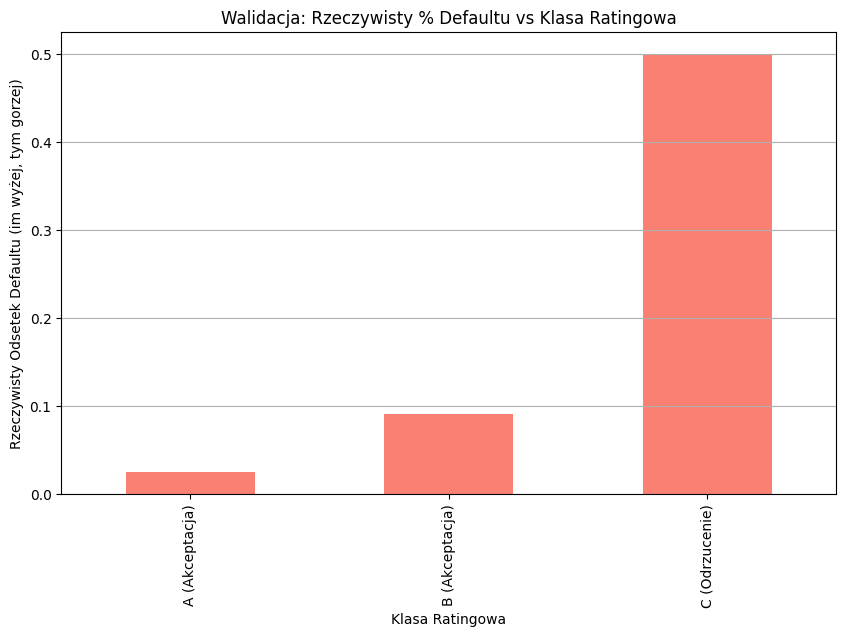


--- Finalna Tabela Decyzyjna / Mapa Ratingowa ---
| Rating         | Średnie_Prognozowane_PD   | Rzeczywisty_Odsetek_Default   | Sugerowana Decyzja Biznesowa      |
|:---------------|:--------------------------|:------------------------------|:----------------------------------|
| A (Akceptacja) | 2.51%                     | 2.51%                         | Akceptacja Automatyczna           |
| B (Akceptacja) | 5.73%                     | 9.02%                         | Odrzucenie (lub Analiza Manualna) |
| C (Odrzucenie) | 23.52%                    | 50.00%                        | Odrzucenie Automatyczne           |


In [27]:
# -----------------------------------------------------------------
# KROK 1: Definicja progów i etykiet ratingowych
# -----------------------------------------------------------------

# Kluczowe jest, aby Twój optymalny próg (0.0450) był jedną z granic!
# Definiujemy progi (bins) dla naszych klas ratingowych.
# Prawa granica (right=False) oznacza, że np. 0.025 należy do 'B', a nie 'A'.
# rating_bins = [
#     0.00,     # Początek
#     0.025,    # Klienci "A" (bardzo niski PD)
#     0.045,    # Klienci "B" (niski PD) <-- GRANICA DECYZJI BIZNESOWEJ
#     0.070,    # Klienci "C" (podwyższone ryzyko, 1. odrzucony)
#     0.15,     # Klienci "D" (wysokie ryzyko)
#     1.01      # Klienci "E" (najgorsi)
# ]
rating_bins = [0.00, 0.045, 0.12, 1.01] 
# Etykiety dla tych klas
rating_labels = [
    "A (Akceptacja)", 
    "B (Akceptacja)", 
    "C (Odrzucenie)"
    # "D (Odrzucenie)", 
    # "E (Odrzucenie)"
]

def pd_to_rating(p, bins, labels):
    """Funkcja mapująca prawdopodobieństwo na etykietę ratingową."""
    return pd.cut(p, bins=bins, labels=labels, right=False, include_lowest=True)

# -----------------------------------------------------------------
# KROK 2: Zastosowanie ratingów i sprawdzenie liczności
# -----------------------------------------------------------------

# Sprawdzamy, czy zmienne istnieją
if 'y_iso_global' in locals() and 'y_test' in locals():
    
    # Używamy Twoich FINALNYCH prognoz po kalibracji i shift'cie do 4%
    final_pd = y_iso_global
    
    # Tworzymy serię z ratingami dla każdej obserwacji w y_test
    ratings = pd_to_rating(final_pd, rating_bins, rating_labels)
    
    print("--- Liczność klientów w każdej klasie ratingowej ---")
    tab_licznosci = pd.crosstab(ratings, columns="Liczność klientów")
    print(tab_licznosci)

    # -----------------------------------------------------------------
    # KROK 3: WALIDACJA - MONOTONICZNOŚĆ (Kluczowy wymóg!)
    # -----------------------------------------------------------------
    
    # Sprawdzamy, czy RZECZYWISTY odsetek defaultu rośnie wraz z ratingiem
    # To jest test, czy nasz model ma sens.
    
    # Tworzymy DataFrame do analizy
    validation_df = pd.DataFrame({
        'Rating': ratings,
        'Predicted_PD': final_pd,
        'Actual_Default': y_test
    })
    
    # Grupujemy i liczymy średnie
    rating_summary = validation_df.groupby('Rating').agg(
        Liczność=('Rating', 'count'),
        Średnie_Prognozowane_PD=('Predicted_PD', 'mean'),
        Rzeczywisty_Odsetek_Default=('Actual_Default', 'mean')
    )
    
    print("\n--- Walidacja Monotoniczności Ratingów ---")
    print(rating_summary)

    # Rysowanie wykresu RZECZYWISTEGO odsetka defaultu
    plt.figure(figsize=(10, 6))
    rating_summary['Rzeczywisty_Odsetek_Default'].plot(kind='bar', color='salmon')
    plt.title("Walidacja: Rzeczywisty % Defaultu vs Klasa Ratingowa")
    plt.xlabel("Klasa Ratingowa")
    plt.ylabel("Rzeczywisty Odsetek Defaultu (im wyżej, tym gorzej)")
    plt.grid(axis='y')
    plt.show()

    # -----------------------------------------------------------------
    # KROK 4: Tabela Decyzyjna (Podsumowanie dla Biznesu)
    # -----------------------------------------------------------------
    
    # Generujemy finalną tabelę decyzyjną
    decision_table = rating_summary[['Średnie_Prognozowane_PD', 'Rzeczywisty_Odsetek_Default']].copy()
    # decision_table['Sugerowana Decyzja Biznesowa'] = [
    #     "Akceptacja Automatyczna",
    #     "Akceptacja Automatyczna",
    #     "Odrzucenie (lub Analiza Manualna)",
    #     "Odrzucenie Automatyczne",
    #     "Odrzucenie Automatyczne"
    # ]

    # POPRAWIONY FRAGMENT (3 elementy)
    # Dostosuj te etykiety, aby pasowały do Twoich 3 nowych grup
    decision_table['Sugerowana Decyzja Biznesowa'] = [
        "Akceptacja Automatyczna",          # Dla Twojej pierwszej, najlepszej grupy
        "Odrzucenie (lub Analiza Manualna)", # Dla Twojej drugiej, środkowej grupy
        "Odrzucenie Automatyczne"           # Dla Twojej trzeciej, najgorszej grupy
    ]
    
    print("\n--- Finalna Tabela Decyzyjna / Mapa Ratingowa ---")
    # Formatowanie dla czytelności
    decision_table['Średnie_Prognozowane_PD'] = decision_table['Średnie_Prognozowane_PD'].map('{:.2%}'.format)
    decision_table['Rzeczywisty_Odsetek_Default'] = decision_table['Rzeczywisty_Odsetek_Default'].map('{:.2%}'.format)
    
    print(decision_table.to_markdown(numalign="left", stralign="left"))

else:
    print("BŁĄD: Brakuje zmiennych 'proba_iso_4pct' lub 'y_test'.")
    print("Upewnij się, że poprzednie komórki kalibracji zostały uruchomione.")